A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

The frog species identified for this challenge is Litoria fallax, the eastern dwarf tree frog pictured below. In addition to assisting our understanding of this specific frog species, a successful frog SDM will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. 

<center>
<img src="pictures/Litoria_fallax.jpg" width="500" height="340">
</center>

<br>

**Challenge aim:** to develop a species distribution model for litoria fallax across Australia using weather data from the TerraClimate dataset.

| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|***1***    | Australia                     | Coarse (4km)  | 1 species  | TerraClimate                                                  |


We will restrict this model to regions in Australia at coarse resolution (4kmx4km), predicting one species against the rest of the 5 specified Australian species using only [TerraClimate](https://planetarycomputer.microsoft.com/dataset/terraclimate) predictor variables. We restrict this analysis to a five year window from the start of 2015 to the end of 2019, and will make the assumption that frog occurrences within that time period are representative of the entire time period (i.e. the frogs take longer than 5 years to move). 


## Load in dependencies


In [189]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = '../'

## Response Variable

Here, we will unzip the data given by EY CHALLENGE to load in the frog occurrences data and generate our response variable.



In [190]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

### Sub-sampling

For this demonstration, we will constrain our search to frogs in Australia found between the start of 2015 to the end of 2019. This gives a varied landscape of bushland, plains, rivers, and urban areas. This is done by providing `year_range` and `bbox` parameters to the get_frogs function we defined above.

In [191]:
# Define the bounding box for Greater Sydney, NSW
region_name = 'Australia'
min_lon, min_lat = (113.04, -43.57)  # Lower-left corner 113.04, -43.57
max_lon, max_lat = (153.66, -10.71)  # Upper-right corner 153.66, -10.71


bbox = (min_lon, min_lat, max_lon, max_lat)


# Load in data
all_frog_data = get_frogs(data_path+'training_data/occurrence.txt', year_range=(2015, 2019), bbox=bbox)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax
...,...,...,...,...,...,...,...,...
193707,2420099493,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.734715,144.328494,Crinia Signifera
193715,2420099296,2016-04-25 00:00:00,Australia,Australia,Victoria,-37.861180,144.268865,Crinia Signifera
193719,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera
193720,2420099687,2016-05-15 00:00:00,Australia,Australia,Victoria,-38.176213,144.355254,Crinia Signifera


### Addressing bias

Below we define some functions to assist in plotting the frog data. This will assist us in identifying two main areas of bias. We then use these functions to plot the frog species distributions of each country. 

In [192]:
def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )

    ax[0].set_title(f"Frog occurrences for {region_name}")
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
    
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

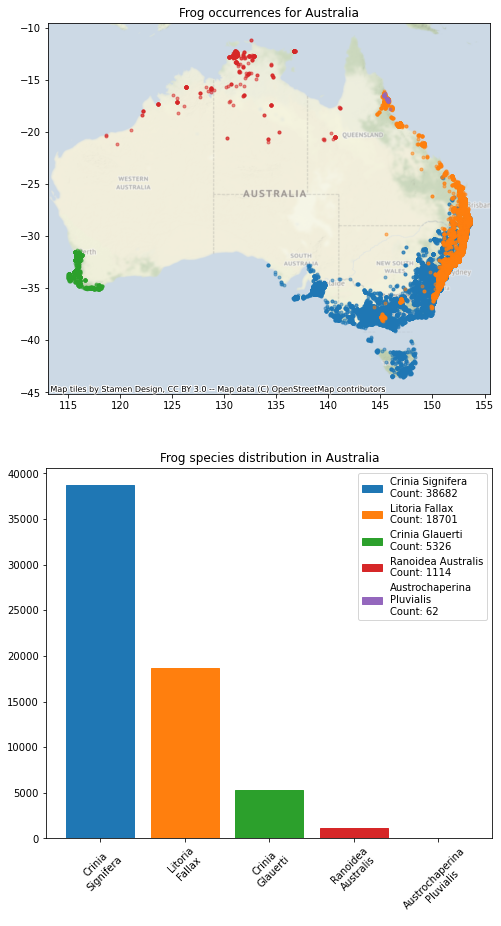

In [193]:
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
plot_species(fig, ax, all_frog_data, region_name)

#### Sampling bias

The plot above shows how frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc. We will use the other species as examples of litoria fallax's absence. We will alter our response variable to be `occurenceStatus` which will take the value of 1 if the occurrence species is litoria fallax, and 0 if the species is not litoria fallax.

In [194]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax,1
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax,1
...,...,...,...,...,...,...,...,...,...
193707,2420099493,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.734715,144.328494,Crinia Signifera,0
193715,2420099296,2016-04-25 00:00:00,Australia,Australia,Victoria,-37.861180,144.268865,Crinia Signifera,0
193719,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera,0
193720,2420099687,2016-05-15 00:00:00,Australia,Australia,Victoria,-38.176213,144.355254,Crinia Signifera,0


#### Class Balancing

Another bias shown in the above visualisations is the class imbalance. To handle this, we will down-sample the absence points so that their numbers match that of the target species. The barcharts below show the response variable before and after the classes have been balanced.

Text(0.5, 1.0, 'Balanced training set')

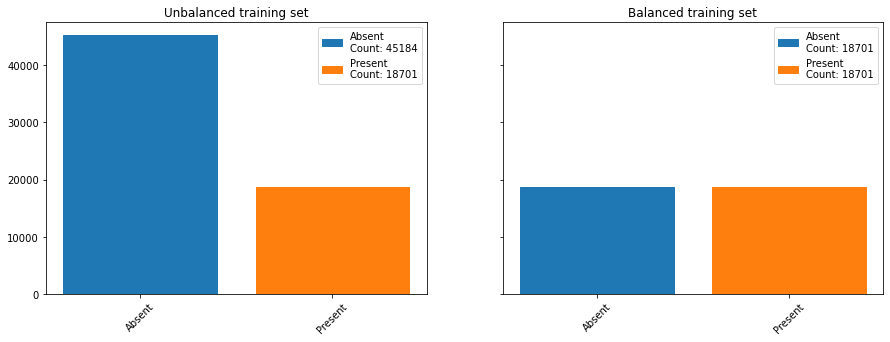

In [195]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]
frog_data = (
    all_frog_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
# Bar charts


fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
bar_data = all_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(bar_data, ax[0], bar_params={})
ax[0].set_title('Unbalanced training set')



balanced_bar_data = frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(balanced_bar_data, ax[1], bar_params={})
ax[1].set_title('Balanced training set')

Text(0.5, 1.0, 'Training set for Australia')

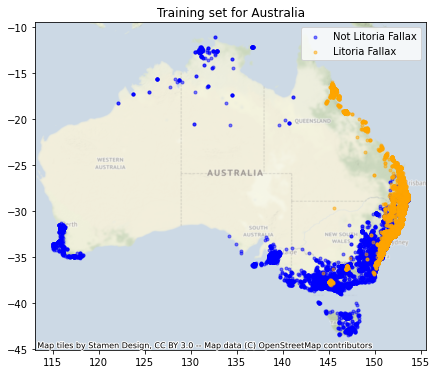

In [196]:
fig, ax = plt.subplots(figsize = (7, 7))

filt = frog_data.occurrenceStatus == 1

ax.scatter(frog_data[~filt].decimalLongitude, frog_data[~filt].decimalLatitude,
           color = 'blue', marker='.', alpha=0.5, label=f"Not {target_species}")
ax.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
           color = 'orange', marker='.', alpha=0.5, label=target_species)
ax.legend()
cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)
ax.set_title(f"Training set for {region_name}")

## Predictor Variables

Now that we have our response variable, it is time to gather the predictor variables from the TerraClimate dataset. 



In [197]:
#check for other parameters

def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

Below, we define the products to take from TerraClimate in `assets` and the metrics to calculate from them in `tc_metrics`. Each metric is applied to each asset, so to pick the desired asset/metric pairs we define a list of strings in the form '\<asset\>_\<metric\>' in `features`. 

In [198]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil', 'ws' ,'swe','def','q','srad','aet','vap']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean','ws_mean','swe_mean','def_mean','q_mean','srad_mean','aet_mean','vap_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'ws_mean',
       'swe_mean', 'def_mean', 'q_mean', 'srad_mean', 'aet_mean',
       'vap_mean'], dtype='<U9')

### Visualising the TerraClimate Data

The spatial distribution of the eleven variables are displayed below.

11


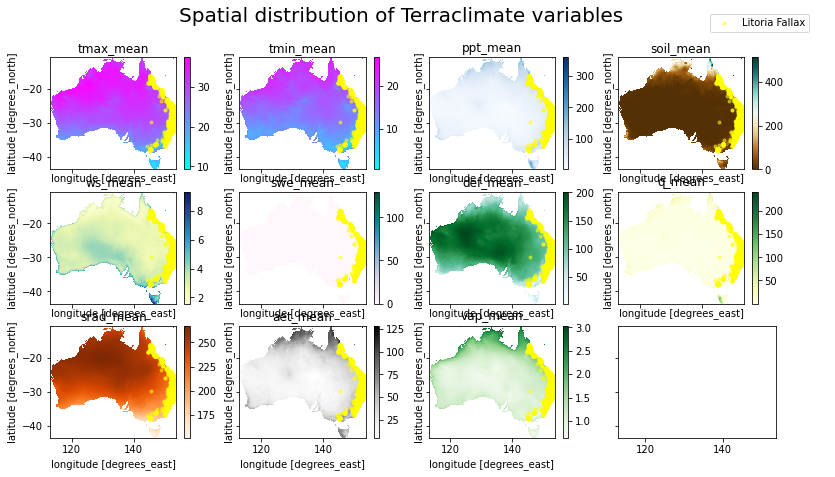

In [199]:
nrow = 3
ncol = 4
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

bands = weather_data.band.values
filt = frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG",'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn','Oranges','Greys','Greens']

print(len(bands))

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

### Feature engineering

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

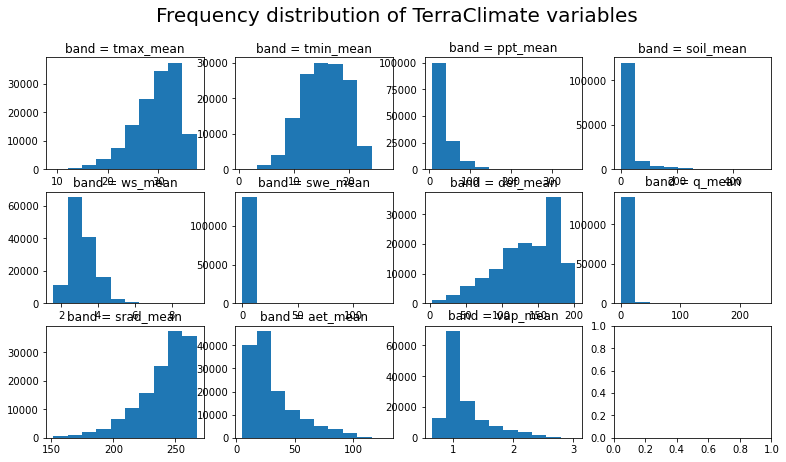

In [200]:
nrow = 3
ncol = 4
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))

bands = weather_data.band.values

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

### Joining Pretictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [201]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
model_data = join_frogs(frog_data, weather_data)
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,...,def_mean,ppt_mean,q_mean,soil_mean,srad_mean,swe_mean,tmax_mean,tmin_mean,vap_mean,ws_mean
0,3463458144,2018-10-09,Australia,Australia,New South Wales,-33.682795,150.558268,Crinia Signifera,0,0,...,36.966667,78.966667,9.566667,40.800000,197.433333,0.0,22.721668,9.871669,1.198167,2.728333
1,3463597125,2019-09-18,Australia,Australia,New South Wales,-33.326500,151.366000,Crinia Signifera,0,1,...,34.433333,91.833333,13.783333,66.666667,196.916667,0.0,23.400001,12.806668,1.416333,3.550000
2,3463509621,2019-07-29,Australia,Australia,Victoria,-37.913300,143.360250,Crinia Signifera,0,2,...,58.050000,47.850000,4.950000,25.800000,179.283333,0.0,19.323335,8.206668,1.018333,4.263333
3,2634632808,2019-08-25,Australia,Australia,South Australia,-37.720980,140.921114,Crinia Signifera,0,3,...,52.600000,56.133333,6.683333,65.666667,179.516667,0.0,19.486668,8.796668,1.075000,4.730000
4,3463472832,2019-06-15,Australia,Australia,Victoria,-37.536900,143.850000,Crinia Signifera,0,4,...,50.750000,58.566667,8.350000,50.200000,180.583333,0.0,18.030002,6.860001,0.919667,4.600000


In [ ]:
model_data['ppt_mean'].fillna(model_data['ppt_mean'].mean(),inplace=True)
model_data['soil_mean'].fillna(model_data['soil_mean'].mean(),inplace=True)
model_data['tmax_mean'].fillna(model_data['tmax_mean'].mean(),inplace=True)
model_data['tmin_mean'].fillna(model_data['tmin_mean'].mean(),inplace=True)
model_data['def_mean'].fillna(model_data['def_mean'].mean(),inplace=True)
model_data['q_mean'].fillna(model_data['q_mean'].mean(),inplace=True)
model_data['ws_mean'].fillna(model_data['ws_mean'].mean(),inplace=True)
model_data['swe_mean'].fillna(model_data['swe_mean'].mean(),inplace=True)
model_data['vap_mean'].fillna(model_data['vap_mean'].mean(),inplace=True)
model_data['srad_mean'].fillna(model_data['srad_mean'].mean(),inplace=True)
model_data['aet_mean'].fillna(model_data['aet_mean'].mean(),inplace=True)

In [203]:
model_data.isna().sum()

gbifID              0
eventDate           0
country             0
continent           0
stateProvince       1
decimalLatitude     0
decimalLongitude    0
species             0
occurrenceStatus    0
key                 0
aet_mean            0
def_mean            0
ppt_mean            0
q_mean              0
soil_mean           0
srad_mean           0
swe_mean            0
tmax_mean           0
tmin_mean           0
vap_mean            0
ws_mean             0
dtype: int64

## Model Building

### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! 

In [204]:
full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key'], 1)
)
y = model_data.occurrenceStatus.astype(int)

# Fit model
full_model.fit(X, y)

LogisticRegression()

### Model Prediction

#### Predict Training Set

Logistic regression is a machine learning model that estimates the probability of a binary response variable. In our case, the model will output the probability of a frog being present at a given location. 

In [205]:
predictions = full_model.predict(X)

#### Predict Entire Region

For a species distribution model to be effective, it must also be capable of performing predictions over the entire region, not just the points in our training set. To do this, we will define another function called `predict_frogs` that will take our interpolated predictor variable image in, along with our logistic regression model, and output the probabilities for each pixel in the region. We will visualise these predictions in a heatmap.

In [206]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, full_model)

### Model Evaluation

Now that we have trained our model and made some predictions, all that is left is to evaluate it. We will do this by first visualising the output of the model with a probability heatmap. Then, we will evaluate both its in-sample and out-of-sample performance using the training set we have generated.

#### In-Sample Evaluation

In the last section, we made our predicitons for the training set and stored them in the `predictions` variable. We can now calculate some performance metrics to guage the effectiveness of the model. 

In [207]:
print(f"F1 Score: {np.mean(f1_score(y, predictions)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y, predictions)).round(2)}") #81,78

F1 Score: 0.81
Accuracy: 0.78


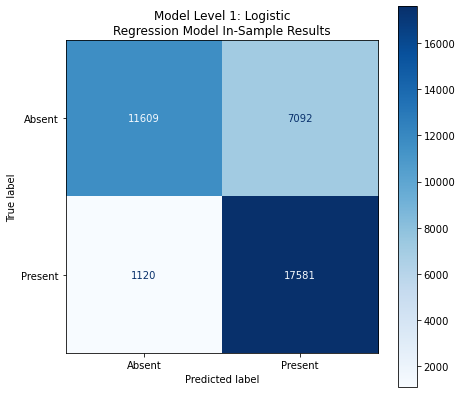

In [208]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

#### Probability Heatmap

To create the probability heatmap, we write a function called `plot_heatmap`. This function will take in the model predictions from the entire region as stored in the `resultant_image` variable, and visualise these probabilities as a heatmap. In addition to the heatmap, we will also plot the actual map of the area in question, and the binary classification regions of the probability heatmap. The latter is simply a binary mask of the probability heatmap, 1 where the probability is greater than 0.5 and 0 elsewhere. 

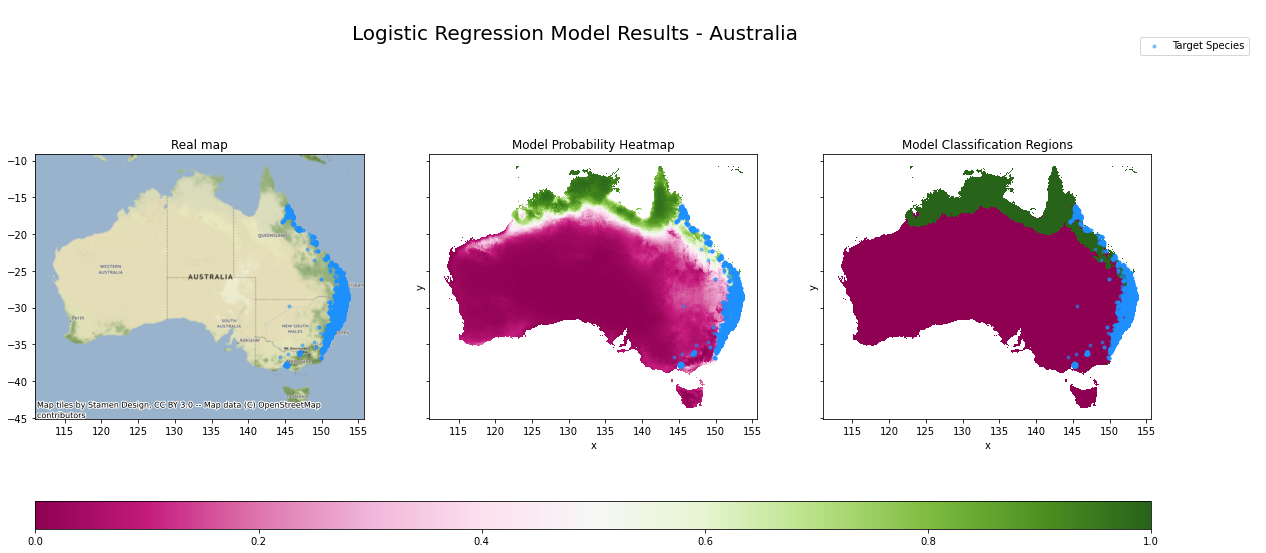

In [209]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    
plot_heatmap(resultant_image, frog_data, f"Logistic Regression Model Results - {region_name}")

From the plots above, we can see that the model does a pretty good job of mapping where litoria fallax is. However, our performance metrics before suggested otherwise. The main limitation of the evaluation metrics comes from the pseudo absence species.


#### Out-of-Sample Evaluation

To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 


In [210]:
cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.81
Accuracy: 0.78


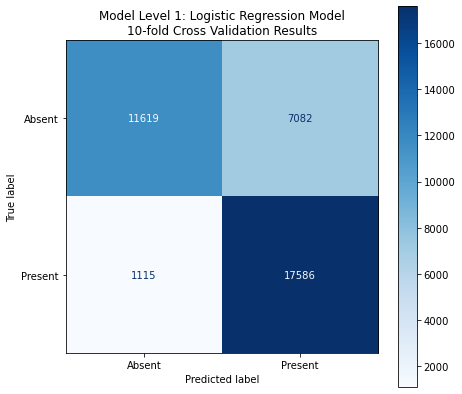

In [211]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(results['actual'], results['predicted'], display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic Regression Model\n10-fold Cross Validation Results')
plt.show()

The results from the 10-fold cross validation are similar to the in-sample metrics. This is a good sign as it shows that we haven't overfit our model. We see similar behavour in the higher rate of false positives that we saw in the in-sample performance. 

As indicators of ecological health and proxies for biological diversity, the disappearance of frogs is of great concern. Where frogs occur, we see healthy, thriving, resilient ecosystems. Where frogs have disappeared, we see ecosystems in poor health. All the 2030 Sustainable Development Goals (SDGs) are underpinned by healthy ecosystems. This means we won’t reach our goals if we don’t prevent and reverse the loss of healthy ecosystems. Thus, the predicted area of existence of Litoria Fallax shows the existence of biological diversity in Australia.